In [2]:
import torch

input = torch.tensor([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]])
m = torch.nn.LayerNorm(input.shape[-1])
print(input.shape)     # 배치 크기(2) x 피처 차원 수(3)
print(input.shape[-1]) # -> 방향으로 레이어 정규화 수행
output = m(input)
print(output)

torch.Size([2, 3])
3
tensor([[-1.2247,  0.0000,  1.2247],
        [ 0.0000,  0.0000,  0.0000]], grad_fn=<NativeLayerNormBackward0>)


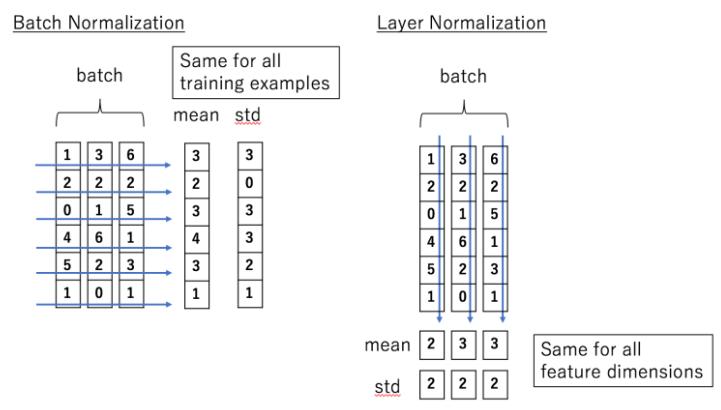

배치정규화는 이전레이어에 가중치를 곱한 결과(액티베이션 출력값)를 채널별로 정규화한다.
채널수(특징 수) 만큼의 평균과 분산을 계산해야 한다.


레이어 정규화는 데이터별로 정규화한다.
그러므로 미니배치 수만큼의 평균과 분산을 계산해야 한다.

a = X * w + b 일때 

배치   정규화 : (a - 채널별 평균(a)) / root(채널별 분산(a)+epsilon) * gamma + beta

레이어 정규화 : (a - 데이터별 평균(a)) / root(데이터별 분산(a)+epsilon) * gamma + beta 

학습 초기 레이어 정규화 수행은 배치 인스턴스의 평균을 빼고 표준편차로 나눈 결과에 1을 곱한 후 0을 더한다는 뜻 -> 이후 학습 과정에서는 태스크를 가장 잘 수행하는 방향으로 이 값들을 업데이트 한다

In [9]:
print(m.weight)
print(m.bias)

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


파이토치로 레이어 정규화 수행

In [7]:
import numpy as np

a = np.array([[1.0, 2.0, 3.0], [1.0, 1.0, 1.0]]) # (2,3)
a_mean = np.mean(a, axis=1)
a_std = np.std(a, axis=1)
print(a_mean)
print(a_std)

[2. 1.]
[0.81649658 0.        ]


드롭아웃: 과적합 현상을 방지하고자 뉴런의 일부를 확률적으로 0으로 대치하여 계산에서 제외하는 기법(학습 과정에서만 적용하고 학습이 끝나고 나서 인퍼런스 과정에서는 적용하지 않는다)

In [16]:
m = torch.nn.Dropout(p=0.2)
input = torch.randn(1,10)
output = m(input)
output

tensor([[-0.0000, -1.1091,  3.5014, -0.4430,  1.2754,  0.8814,  0.0000, -1.3042,
          0.3551, -0.5158]])

In [ ]:
# from torch.optim import Adam
# optimizer = Adam(model.parameters(), lr=model.learning_rate)